# Notebook to compare automatically detected snowline elevations to USGS ELA estimates

In [1]:
# ----Import packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import glob
from scipy.stats import iqr
import os

In [2]:
# -----Define paths in directory
# path to USGS mass balance data
usgs_path = '/Users/raineyaberle/Google Drive/My Drive/Research/PhD/GIS_data/USGS/benchmarkGlacier_massBalance/'
# path to study-sites/
study_sites_path = '/Users/raineyaberle/Research/glacier_snow_cover_mapping/study-sites/'
# path to glacier-snow-cover-mapping/
base_path = '/Users/raineyaberle/Research/glacier_snow_cover_mapping/glacier-snow-cover-mapping/'

Wolverine
Gulkana
LemonCreek
SouthCascade


/var/folders/9h/sg2rw9f10lq5jmfch9hnj6gc0000gq/T/ipykernel_6574/1024734657.py:30: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  usgs['Ba_Date'] = pd.to_datetime(usgs['Ba_Date'])


Sperry


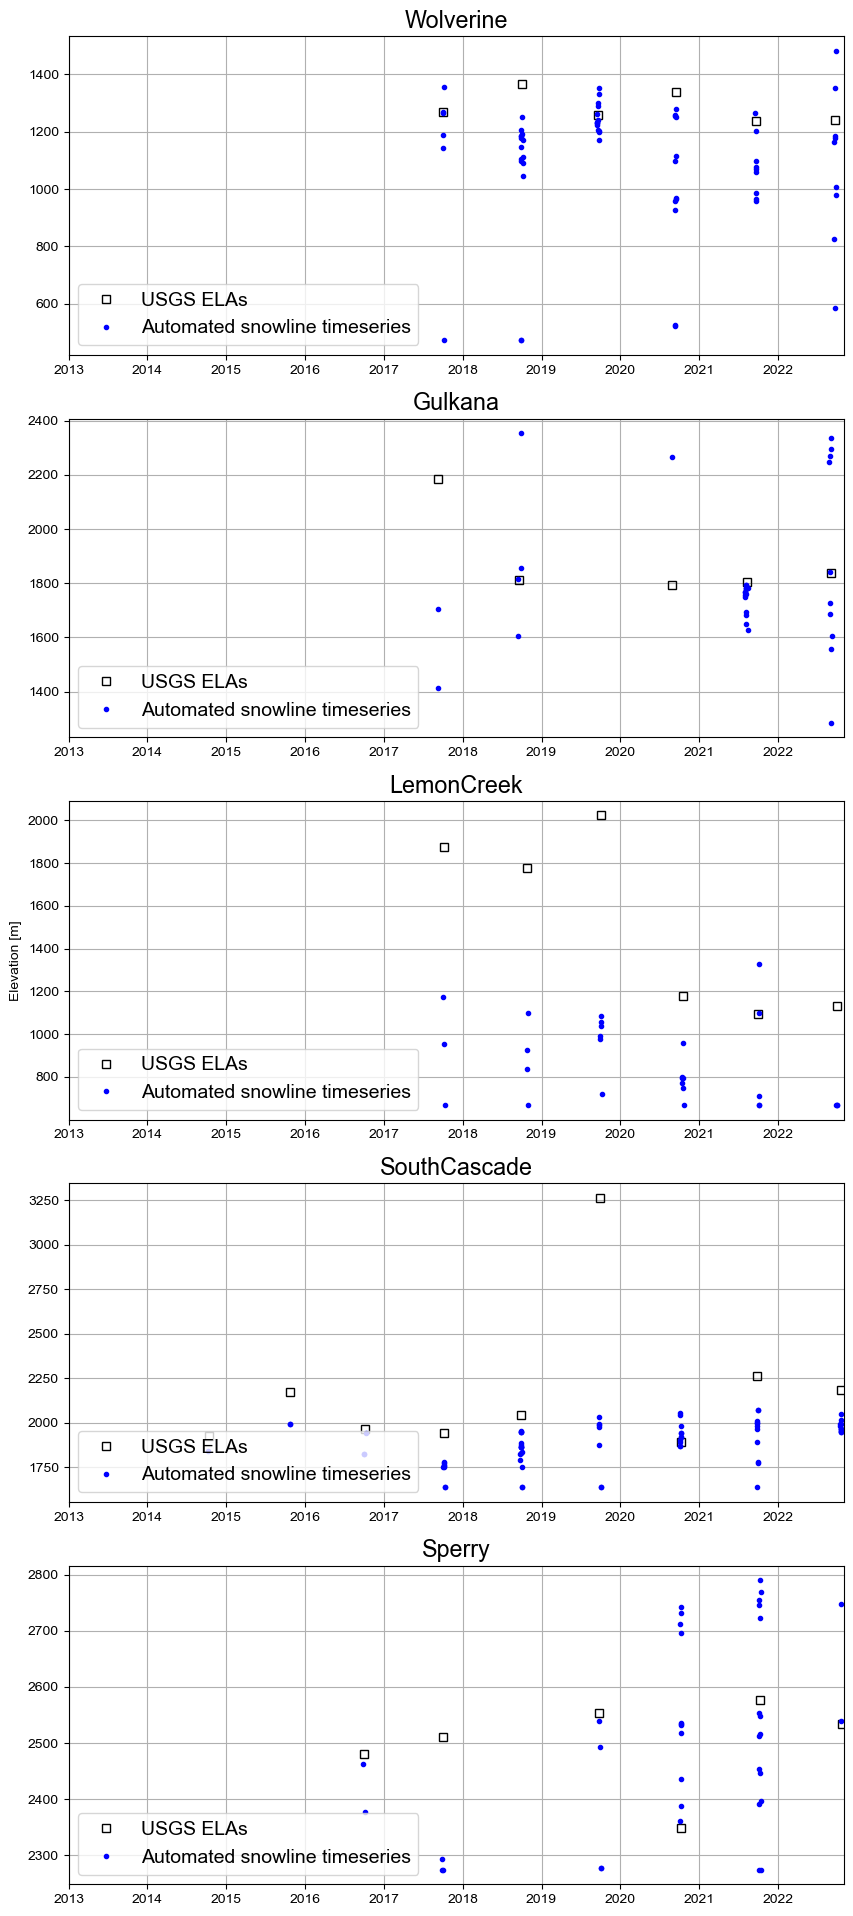

In [3]:
site_names = ['Wolverine', 'Gulkana', 'LemonCreek', 'SouthCascade', 'Sperry']

# set up figure
fig, ax = plt.subplots(len(site_names), 1, figsize=(10,24))
plt.rcParams.update({'font.size':14, 'font.sans-serif':'Arial'})

# initialize stats dataframe
results = pd.DataFrame()
sl_ests_full = pd.DataFrame()
usgs_full = pd.DataFrame()

# loop through sites
for i, site_name in enumerate(site_names):
    
    print(site_name)
    
    # load estimated snow lines  
    sl_est_fns = glob.glob(study_sites_path + site_name + '/imagery/snowlines/*snowline.csv')
    sl_ests = gpd.GeoDataFrame()
    for sl_est_fn in sl_est_fns:
        sl_est = pd.read_csv(sl_est_fn)
        sl_ests = pd.concat([sl_ests, sl_est])
    sl_ests.reset_index(drop=True, inplace=True)
    sl_ests['datetime'] = pd.to_datetime(sl_ests['datetime'], format='mixed')
    sl_ests_full = pd.concat([sl_ests_full, sl_ests])
    
    # load USGS data
    usgs_fn = usgs_path + site_name + '/Output_' + site_name + '_Glacier_Wide_solutions_calibrated.csv'
    usgs = pd.read_csv(usgs_fn)
    usgs['Ba_Date'] = pd.to_datetime(usgs['Ba_Date'])
    usgs['site_name'] = site_name
    usgs_full = pd.concat([usgs_full, usgs])
    
    # grab unique years in snowline time series
    unique_years = np.unique(sl_ests['datetime'].values.astype('datetime64[Y]'))
    # loop through unique years
    labeled=False # whether label has been added to axis legend
    for unique_year in unique_years:
        # grab USGS ELAs
        usgs_year = usgs.iloc[usgs['Ba_Date'].values.astype('datetime64[Y]')==unique_year]
        # grab all snowlines within 1 week of USGS observation
        threshold = np.timedelta64(7, 'D')
        sl_ests_year = sl_ests.loc[np.abs(sl_ests['datetime'].values.astype('datetime64[D]')
                                   - usgs_year['Ba_Date'].values.astype('datetime64[D]')[0]) < threshold]
            
        # calculate difference statistics, add to dataframe
        if len(sl_ests_year) > 1:
            result = pd.DataFrame({'Site name': [site_name],
                                   'Year': [str(unique_year)],
                                   'USGS Ba Date': [str(usgs_year['Ba_Date'].values[0])[0:10]],
                                   'USGS ELA [m]': [usgs_year['ELA'].values[0]],
                                   'Snowline date(s)': [sl_ests_year['datetime'].values],
                                   'Snowline median elevations [m]': [sl_ests_year['snowline_elevs_median_m'].values],
                                   'Median snowline median elevations [m]': [np.nanmedian(sl_ests_year['snowline_elevs_median_m'].values)],
                                   'Difference median [m]': [np.nanmedian(sl_ests_year['snowline_elevs_median_m'].values - usgs_year['ELA'].values)],
                                   'Difference IQR [m]': [iqr(sl_ests_year['snowline_elevs_median_m'].values - np.nanmedian(usgs_year['ELA'].values), nan_policy='omit')],
                                   'Difference mean [m]': [np.nanmean(sl_ests_year['snowline_elevs_median_m'].values - np.nanmedian(usgs_year['ELA'].values))],
                                   'Difference std. [m]': [np.nanstd(sl_ests_year['snowline_elevs_median_m'].values - np.nanmedian(usgs_year['ELA'].values))],
                                   'N': [len(sl_ests_year)]
                                  })
            # plot
            if labeled==False:
                ax[i].plot(usgs_year['Ba_Date'], usgs_year['ELA'], linestyle='None', marker='s', markerfacecolor='None', markeredgecolor='k', label='USGS ELAs')
                ax[i].plot(sl_ests_year['datetime'], sl_ests_year['snowline_elevs_median_m'], '.b', label='Automated snowline timeseries')
                labeled=True # don't add any more labels to legend
            else:
                ax[i].plot(usgs_year['Ba_Date'], usgs_year['ELA'], linestyle='None', marker='s', markerfacecolor='None', markeredgecolor='k')
                ax[i].plot(sl_ests_year['datetime'], sl_ests_year['snowline_elevs_median_m'], '.b')
        else:
            result = pd.DataFrame({'Site name': [site_name],
                                   'Year': [str(unique_year)],
                                   'USGS Ba Date': [str(usgs_year['Ba_Date'].values[0])[0:10]],
                                   'USGS ELA [m]': [usgs_year['ELA'].values[0]],
                                   'Snowline date(s)': [np.datetime64('NaT')],
                                   'Snowline median elevations [m]': np.nan,
                                   'Median snowline median elevations [m]': np.nan,
                                   'Difference median [m]': np.nan,
                                   'Difference IQR [m]': np.nan,
                                   'Difference mean [m]': np.nan,
                                   'Difference std. [m]': np.nan,
                                   'N': [0]
                                  })
        results = pd.concat([results, result])
        # add column for average stats for all years
        if unique_year==unique_years[-1]:
            result = pd.DataFrame({'Site name': [site_name + ' AVERAGE'],
                                   'Year': 'N/A',
                                   'USGS Ba Date': 'N/A',
                                   'USGS ELA [m]': 'N/A',
                                   'Snowline date(s)': 'N/A',
                                   'Snowline median elevations [m]': 'N/A',
                                   'Median snowline median elevations [m]': 'N/A',
                                   'Difference median [m]': [np.nanmean(results.loc[results['Site name']==site_name]['Difference median [m]'].values)],
                                   'Difference IQR [m]': [np.nanmean(results.loc[results['Site name']==site_name]['Difference IQR [m]'].values)],
                                   'Difference mean [m]': [np.nanmean(results.loc[results['Site name']==site_name]['Difference mean [m]'].values)],
                                   'Difference std. [m]': [np.nanmean(results.loc[results['Site name']==site_name]['Difference std. [m]'].values)],
                                   'N': 'N/A'
                                  })
            results = pd.concat([results, result])
        
    ax[i].grid()
    ax[i].set_title(site_name)
    ax[i].legend(loc='lower left')
    if i==2:
        ax[i].set_ylabel('Elevation [m]')
    ax[i].set_xlim(np.datetime64('2013-01-01'), np.datetime64('2022-11-01'))
    
plt.show()

# add column for average of all sites
result = pd.DataFrame({'Site name': ['ALL SITES AVERAGE'],
                       'Year': 'N/A',
                       'USGS Ba Date': 'N/A',
                       'USGS ELA [m]': 'N/A',
                       'Snowline date(s)': 'N/A',
                       'Snowline median elevations [m]': 'N/A',
                       'Median snowline median elevations [m]': 'N/A',
                       'Difference median [m]': [np.nanmean(results['Difference median [m]'].values)],
                       'Difference IQR [m]': [np.nanmean(results['Difference IQR [m]'].values)],
                       'Difference mean [m]': [np.nanmean(results['Difference mean [m]'].values)],
                       'Difference std. [m]': [np.nanmean(results['Difference std. [m]'].values)],
                       'N': 'N/A'
                      })
results = pd.concat([results, result])
results.reset_index(drop=True, inplace=True)

# save results and figure to file
# fig_fn = 'USGS_ELA_comparison.png'
# fig.savefig(base_path + 'figures/' + fig_fn, dpi=200, facecolor='w', edgecolor='none', bbox_inches='tight')
# print('figure saved to file: ' + base_path + 'figures/' + fig_fn)
# results_fn = 'USGS_ELA_comparison_stats.csv'
# results.to_csv(base_path + 'inputs-outputs/' + results_fn, index=False)
# print('results stats saved to file: ' + base_path + 'inputs-outputs/' + results_fn)

## Plot scatterplot of ELA magnitude and timing comparison

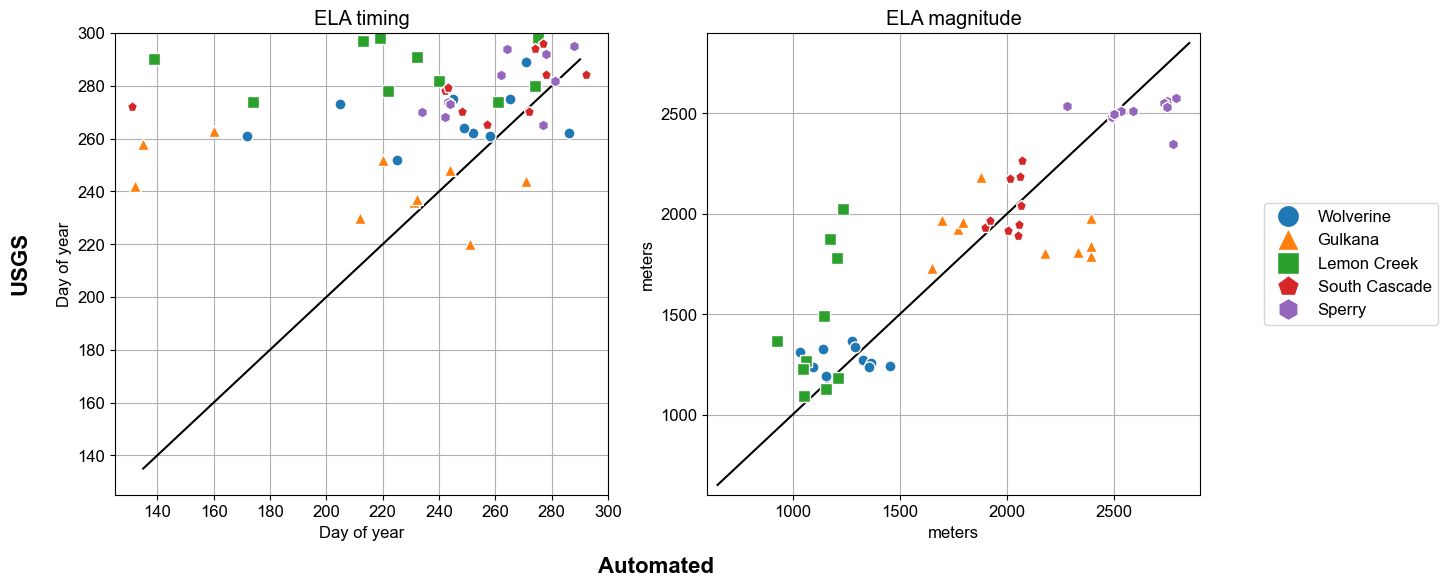

figure saved to file: /Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/figures/USGS_ELA_comparison.png


In [6]:
# drop average columns
Idrop = results.loc[(results['Site name']=='Wolverine AVERAGE') | (results['Site name']=='Gulkana AVERAGE') 
                    | (results['Site name']=='LemonCreek AVERAGE') | (results['Site name']=='SouthCascade AVERAGE')
                    | (results['Site name']=='Sperry AVERAGE') | (results['Site name']=='ALL SITES AVERAGE')].index
results_no_ave = results.drop(Idrop)

# make dates datetime format
results_no_ave['USGS Ba Date'] = pd.to_datetime(results_no_ave['USGS Ba Date'])

# plot
fontsize=12
plt.rcParams.update({'font.size':fontsize, 'font.sans-serif':'Arial'})
fig, ax = plt.subplots(1, 2, figsize=(14,6))
xmin1, xmax1 = 125, 300
xmin2, xmax2 = 600, 2900
markers = ['o', '^', 's', 'p', 'h']
# linear fit lines
ax[0].plot([xmin1+10, xmax1-10], [xmin1+10, xmax1-10], '-k')
ax[1].plot([xmin2+50, xmax2-50], [xmin2+50, xmax2-50], '-k')
# add DOY columns to snowlines and usgs dataframes
sl_ests_full['DOY'] = sl_ests_full.datetime.dt.dayofyear
usgs_full['Ba_Date_DOY'] = usgs_full['Ba_Date'].dt.dayofyear
# iterate over sites
for i, site_name in enumerate(site_names):
    # subset snowlines
    sl_ests_site = sl_ests_full.loc[sl_ests_full['site_name']==site_name]
    sl_ests_site_noPS = sl_ests_site.loc[sl_ests_site['dataset']!='PlanetScope']
    # subset usgs
    usgs_full_site = usgs_full.loc[usgs_full['site_name']==site_name]
    # grab rows with maximum snowline elevations
    max_value_rows = sl_ests_site_noPS.loc[sl_ests_site_noPS.groupby(sl_ests_site_noPS.datetime.dt.year)['snowline_elevs_median_m'].idxmax()]
    # plot dates
    ax[0].plot(max_value_rows['DOY'], usgs_full_site.loc[usgs_full_site['Year'] >= 2013, 'Ba_Date_DOY'], 
               marker=markers[i], linestyle='None', markeredgecolor='w', markersize=8)
    # plot magnitudes
    ax[1].plot(max_value_rows['snowline_elevs_median_m'], usgs_full_site.loc[usgs_full_site['Year'] >=2013, 'ELA'], 
               marker=markers[i], linestyle='None', markersize=8, markeredgecolor='w', label=site_name.replace('C', ' C'))
ax[0].set_xlim(xmin1, xmax1)
ax[0].set_ylim(xmin1, xmax1)
ax[0].grid()
ax[0].set_ylabel('Day of year')
ax[0].set_xlabel('Day of year')
ax[0].set_title('ELA timing')
ax[1].set_xlabel('meters')
ax[1].set_ylabel('meters')
ax[1].set_title('ELA magnitude')
ax[1].set_xlim(xmin2, xmax2)
ax[1].set_ylim(xmin2, xmax2)
ax[1].legend(loc='center right', bbox_to_anchor=[1.3, 0.4, 0.2, 0.2], markerscale=2)
fig.text(0.47, -0.02, 'Automated', fontsize=fontsize+4, fontweight='bold')
fig.text(0.05, 0.45, 'USGS', fontsize=fontsize+4, fontweight='bold', rotation=90)
plt.grid()
plt.show()

# save figure
fig_fn = os.path.join(base_path, 'figures', 'USGS_ELA_comparison.png')
fig.savefig(fig_fn, dpi=300, bbox_inches='tight')
print('figure saved to file: ' + fig_fn)